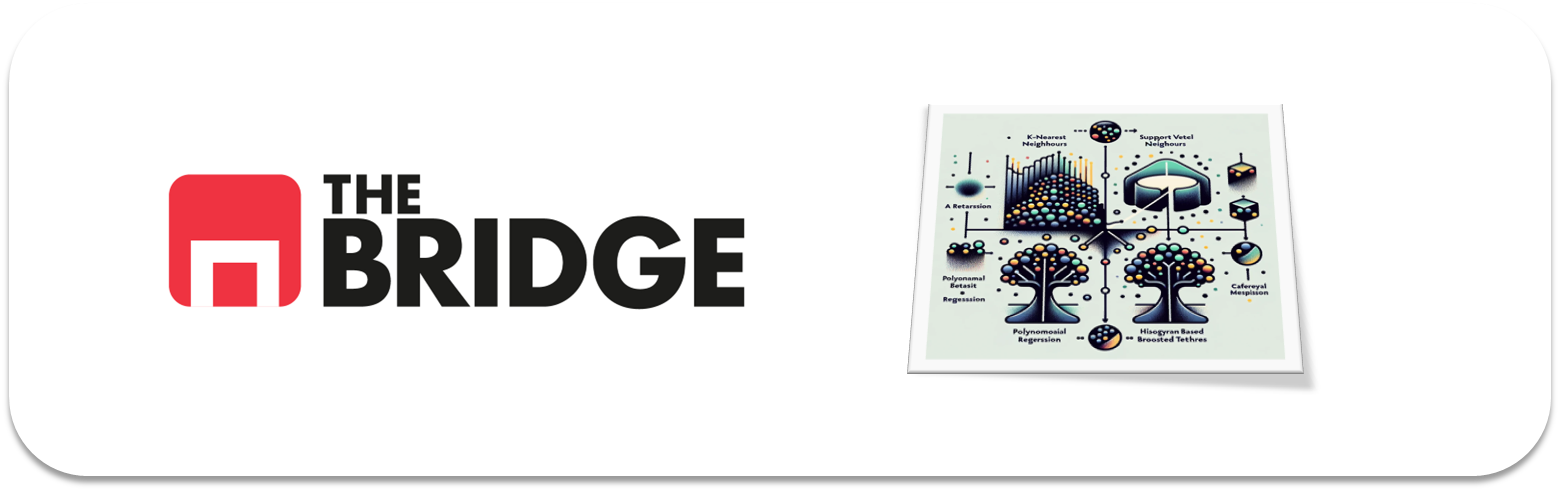

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from xgboost import XGBClassifier



### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

*Cargamos datos, echamos un vistazo y buscamos la descripción*

In [2]:
df = pd.read_csv("./data/credit_npo.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

*Así de primeras "Monthlty Income" y "NumberOfDependents" necesitan tratamiento de esos missings, que haremos una vez hecho el split en train y test*

*Tirando de herramientas chatteras:*

1. **SeriousDlqin2yrs**: Variable dependiente/binaria. Indica si el individuo experimentó morosidad de 90 días o más en los próximos dos años al momento de la toma de datos. Un valor de 1 indica que sí experimentó dificultades financieras serias, y 0 en caso contrario.

2. **RevolvingUtilizationOfUnsecuredLines**: Proporción del crédito utilizado por el consumidor en relación con todas sus líneas de crédito disponibles sin garantía (como tarjetas de crédito).

3. **age**: Edad del prestatario en años.

4. **NumberOfTime30-59DaysPastDueNotWorse**: Número de veces que el prestatario ha estado retrasado entre 30 y 59 días en sus pagos, pero no peor en los últimos 2 años.

5. **DebtRatio**: Relación deuda/ingreso. Es una medida de la carga de deuda del prestatario, calculada como sus pagos mensuales de deuda divididos por su ingreso mensual.

6. **MonthlyIncome**: Ingreso mensual del prestatario.

7. **NumberOfOpenCreditLinesAndLoans**: Número de préstamos abiertos y líneas de crédito (como préstamos para automóviles, hipotecas, préstamos personales, etc.).

8. **NumberOfTimes90DaysLate**: Número de veces que el prestatario ha estado retrasado más de 90 días en sus pagos.

9. **NumberRealEstateLoansOrLines**: Número de préstamos o líneas de crédito inmobiliarios, incluyendo hipotecas y líneas de crédito con garantía hipotecaria.

10. **NumberOfTime60-89DaysPastDueNotWorse**: Número de veces que el prestatario ha estado retrasado entre 60 y 89 días en sus pagos, pero no peor en los últimos 2 años.

11. **NumberOfDependents**: Número de dependientes que el prestatario tiene en su familia, excluyéndose a sí mismo.



*En esta ocasión para hacer una rápida clasificación en categóricas y numéricas miraré el describe porque todas aparecen como tipo numérico*

In [4]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,12537.000000,12537.000000,12537.000000,12537.000000,12537.000000,11816.000000,12537.000000,12537.000000,12537.000000,12537.000000,12360.000000
mean,0.068916,0.330359,52.079445,0.409588,1.902253,6864.815420,8.482332,0.259312,0.999202,0.228364,0.822087
std,0.253321,0.368148,15.077498,4.055787,9.122216,11855.905437,5.165422,4.035658,1.134325,4.018873,1.136802
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030651,41.000000,0.000000,0.142268,3498.750000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.163490,51.000000,0.000000,0.302025,5416.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.582219,62.000000,0.000000,0.506725,8300.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,6.000000,101.000000,98.000000,99.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


*Veo que hay outliers potentes en algunas variables (lo tendré que tener en cuenta si voy a estandarizar para hacer transformaciones primero) y en general son todas para considerar como numéricas continuas, salvo quizás "NumberOfDependents" que lo que haré será (después de imputarla) tratarla como numérica y categórica en el MiniEDA para decidir si tengo que tratarla luego de una u otra manera (como categórica no la trataría porque ya es "ordinal")*

### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

*Es un problema de clasificación binaria (estará o no en problemas financieros en los dos próximos años)*  
*La variable target es 'SeriousDlqin2yrs'* 

### #1.3
Pinta la distribución de frecuencias del target y coméntala

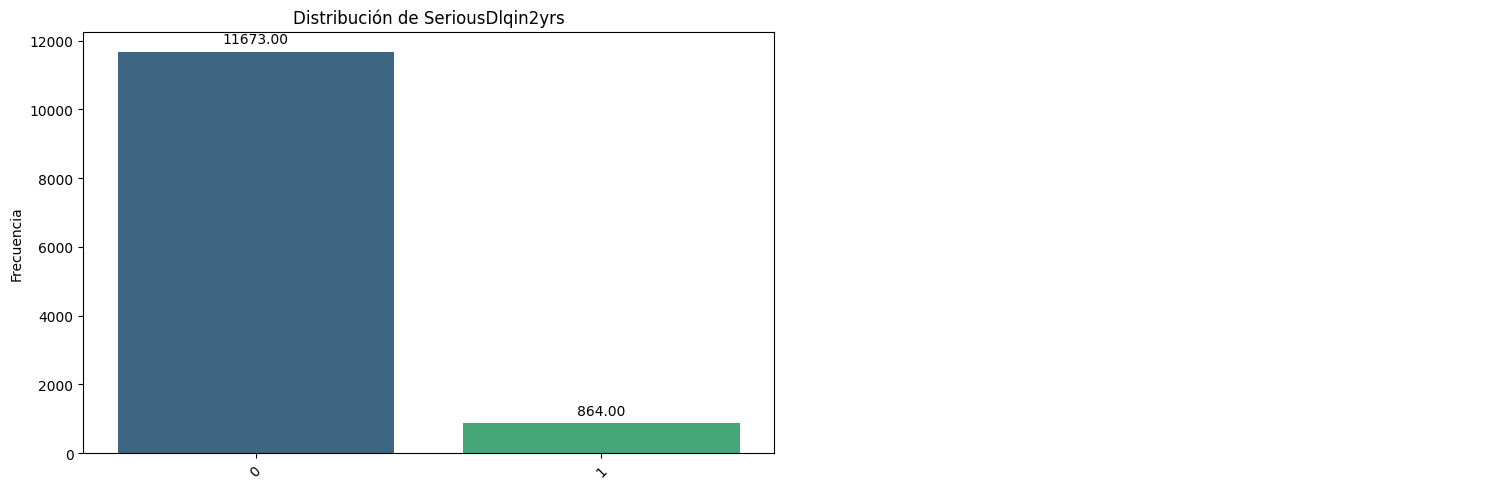

In [5]:
target = "SeriousDlqin2yrs"

bt.pinta_distribucion_categoricas(df,[target], mostrar_valores= True)

*El target esta muy desequilibrado o muy desbalanceado. Aplicaremos lo visto en el workout tanto Oversampling, como Undersampling como equilibrado con hiperparámetro*

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este con y sin datasets tratados y elige el mejor.

**1. Limpieza**

*Como lo que tenemos que hacer es imputar variables numéricas lo dejamos para después del split. El resto, se puede comprobar, está bastante limpio y no parece haber valores especiales (tipo -1 o 9999999, como puedes comprobar en el describe que hicimos antes)*

**2. Train-Test**

In [6]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

**3. Imputaciones**

*En el caso de "NumberOfDepedentes" es numérica discreta así que no vamos a imputar media, podríamos imputar mediana, pero vamos a hacerlo con la moda*

In [7]:
# Primero las asigno a variables para simplificar el tecleteo :-)
ndp = "NumberOfDependents"
mi = "MonthlyIncome"

In [8]:
# Con "NumberOfDependents", imputo la moda
moda_train = train_set[ndp].mode()
print(moda_train) # Compruebo que no hay más de un valor

0    0.0
Name: NumberOfDependents, dtype: float64


*Imputamos train y test*

In [9]:
moda_train = moda_train[0] # lo convierto en un valor (antes era un serie de pandas)
train_set[ndp] = train_set[ndp].fillna(moda_train)
test_set[ndp] = test_set[ndp].fillna(moda_train)

*Ahora con MonthlyIncome, pinto la distribución para decidir si uso media o mediana*

(2,)


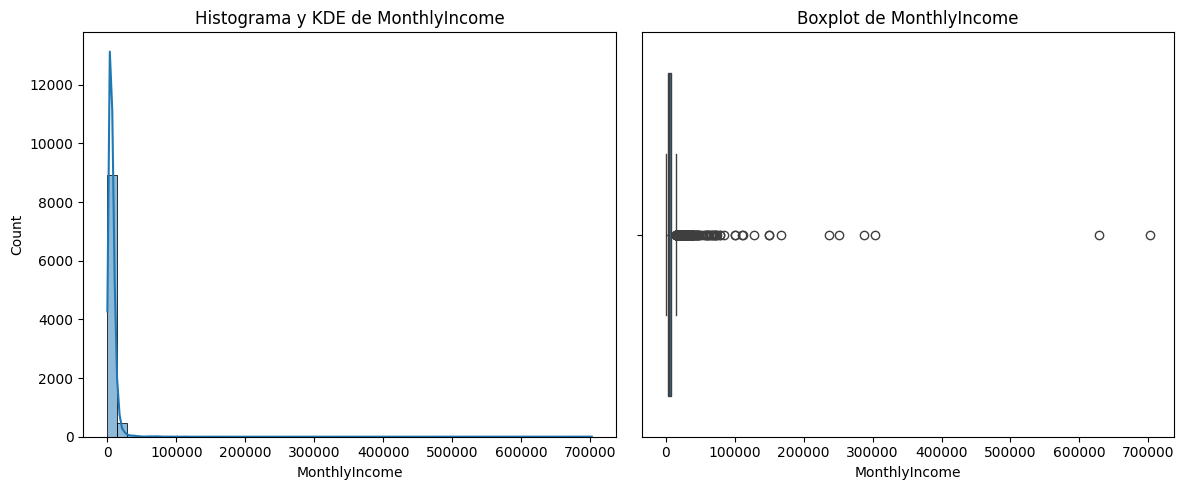

In [10]:
bt.plot_combined_graphs(train_set, columns=[mi], bins = 50) # Uso 100000 porque en el boxplot anterior es donde parece que empiezan a separarse, a no estar tan concentrados, más los "outliers"

*Tiene mucho outlier extremo es muy heavy-tail, así que usaré la mediana y me apunto esa presencia de outliers porque tendré que transformar en algún momento si quiero escalar*

In [11]:
mediana = train_set[mi].quantile(0.5)
train_set[mi] = train_set[mi].fillna(mediana)
test_set[mi] = test_set[mi].fillna(mediana)

**4. MiniEDA**

*Considerando "NumberOfDependents" como categórica la analizo contra el target*

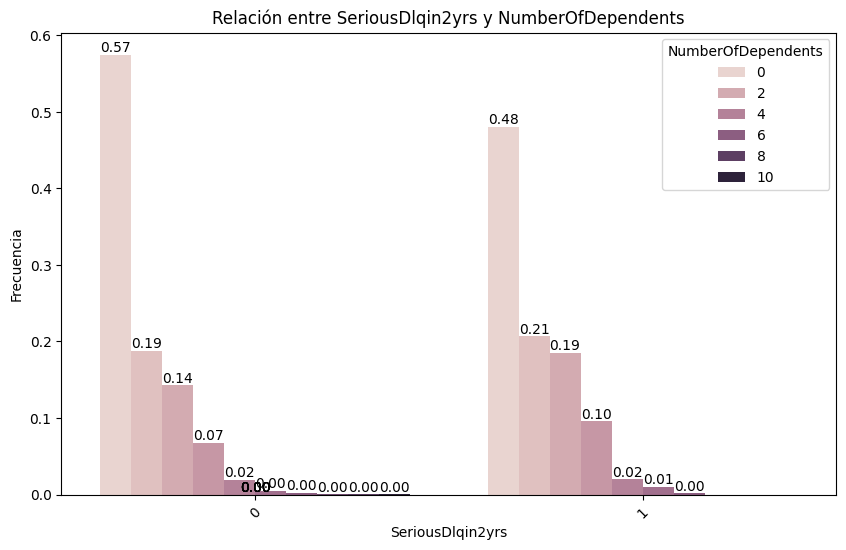

In [12]:
bt.plot_categorical_relationship_fin(train_set, target, ndp, show_values= True, relative_freq= True)

*Así tal cual, distribuciones de figura similar, y valores muy parecidos, ni la incluiría, vamos a ver el análisis de variables numéricas incluyéndola*

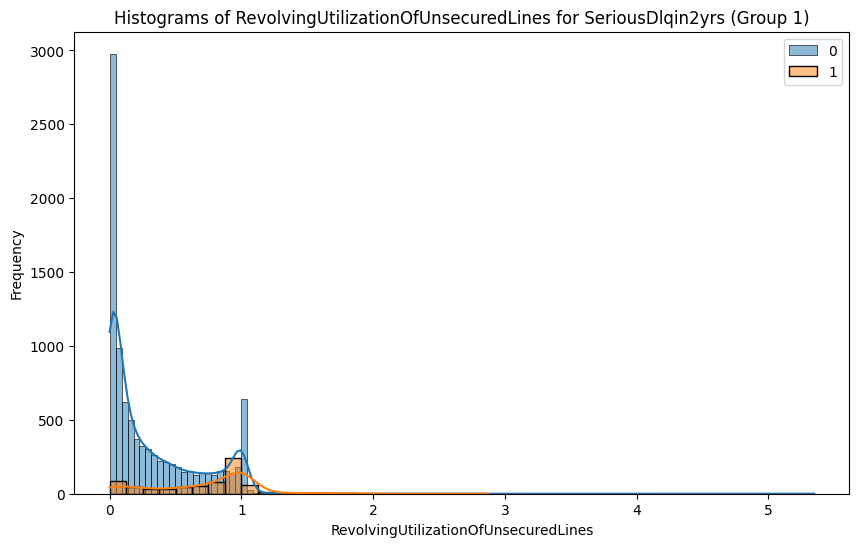

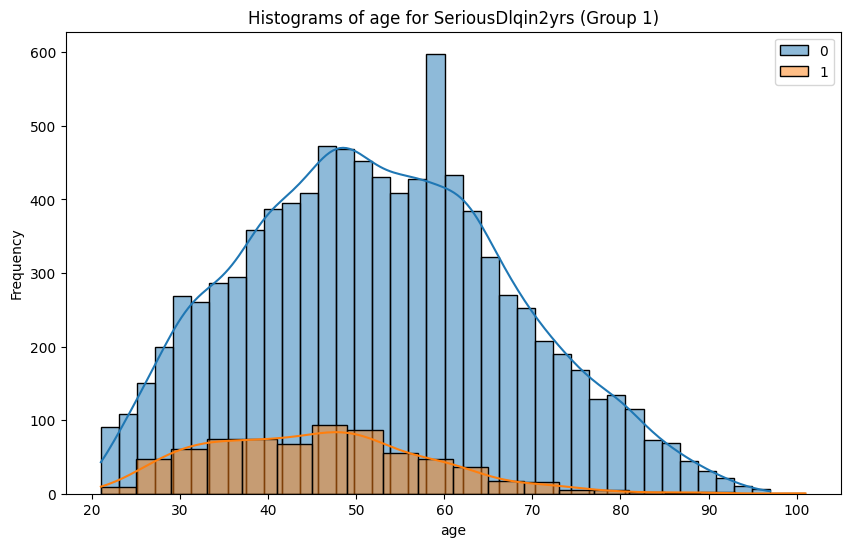

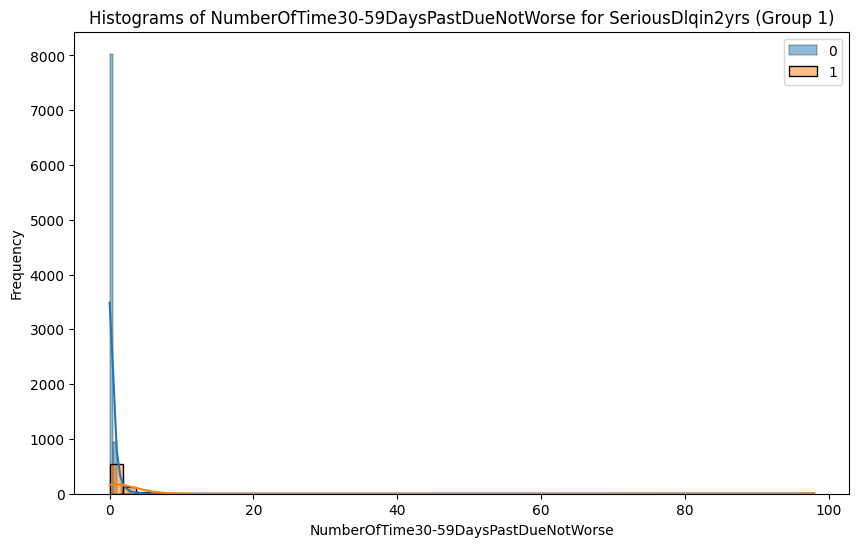

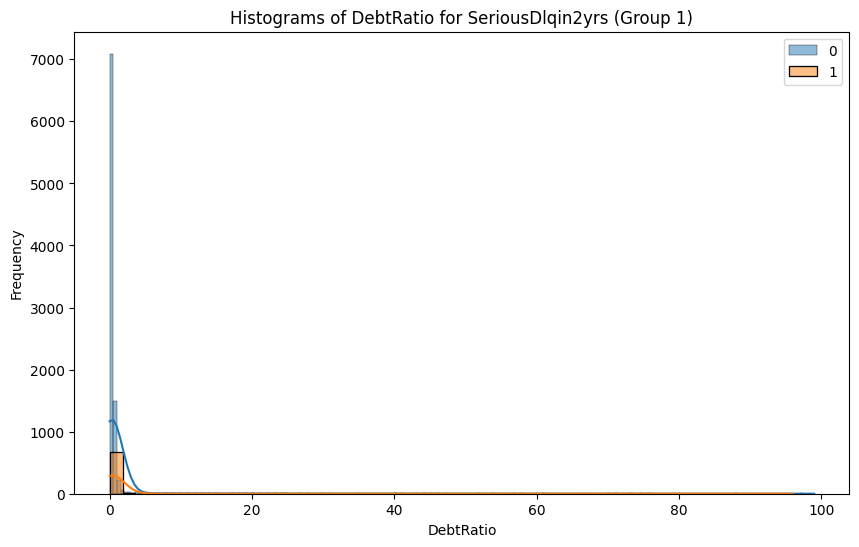

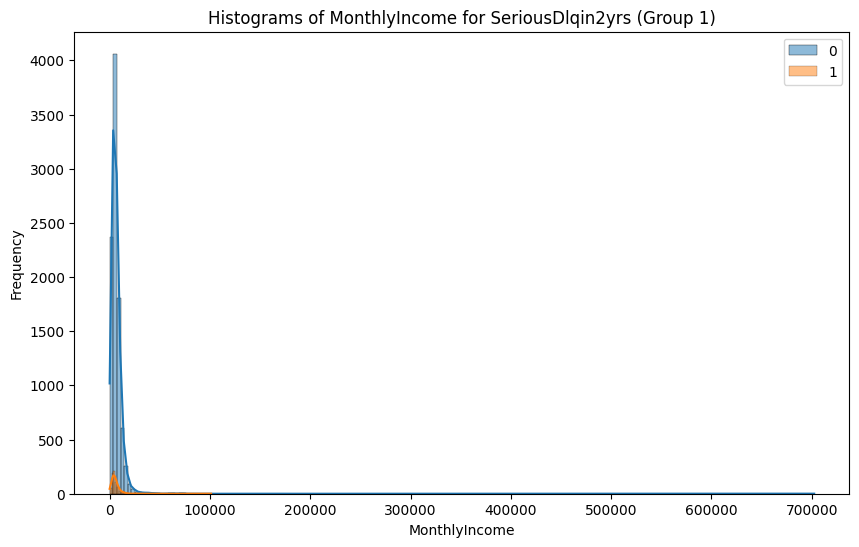

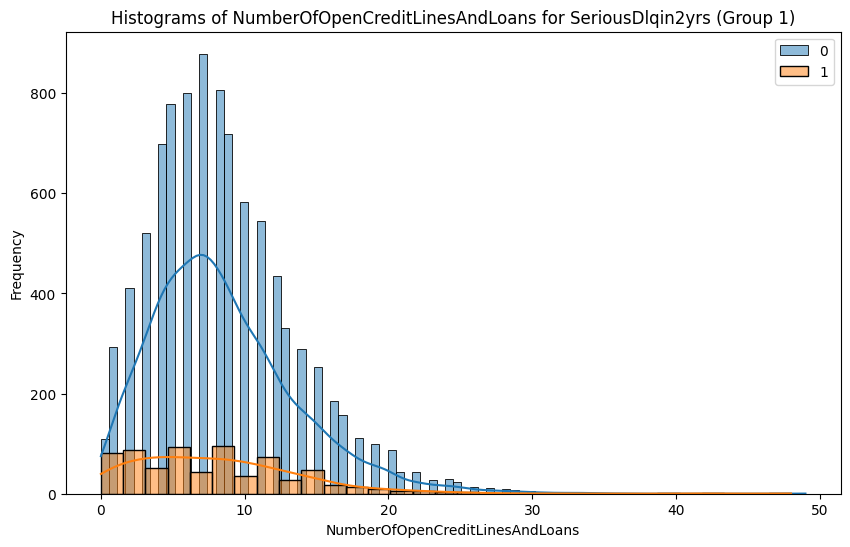

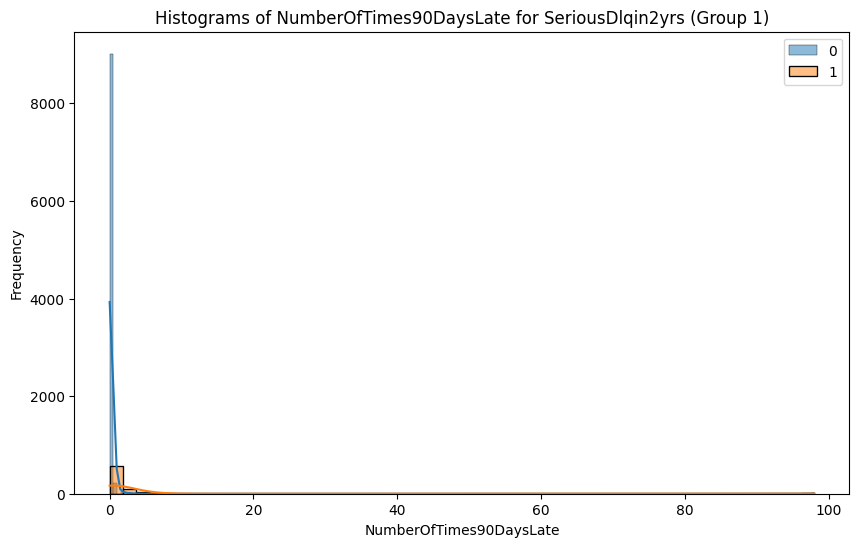

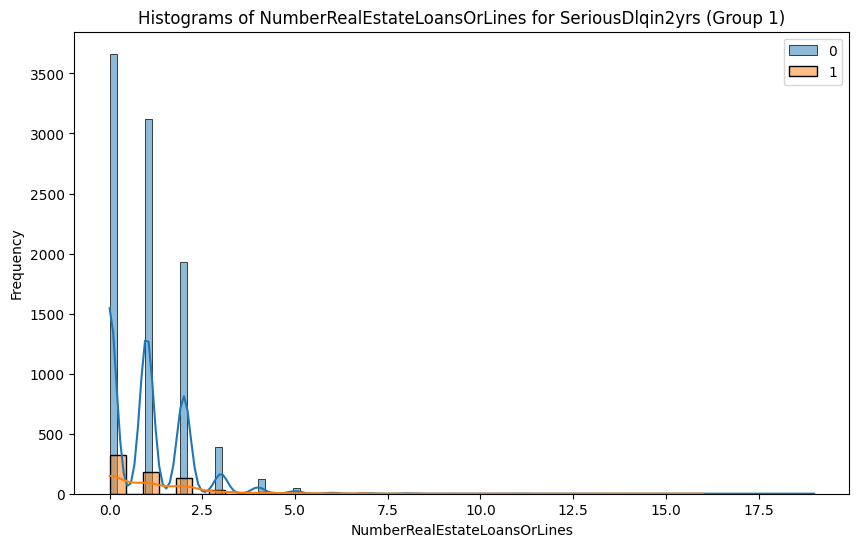

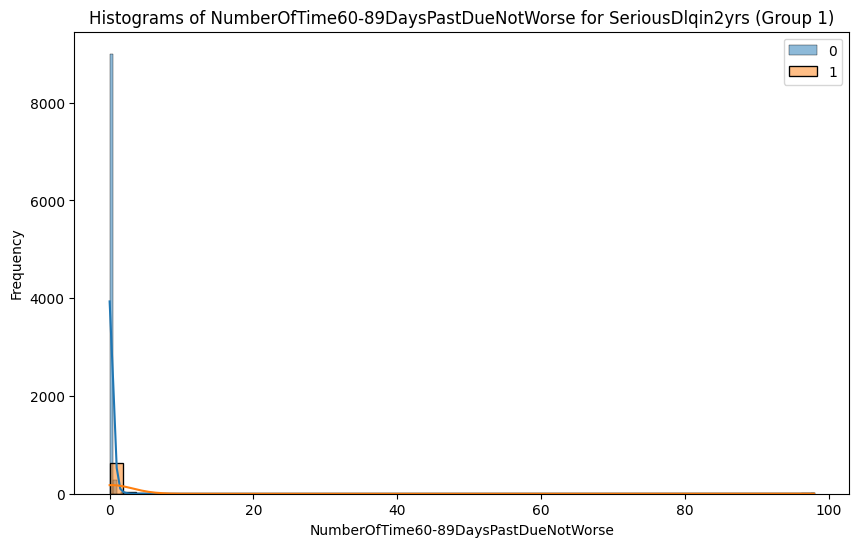

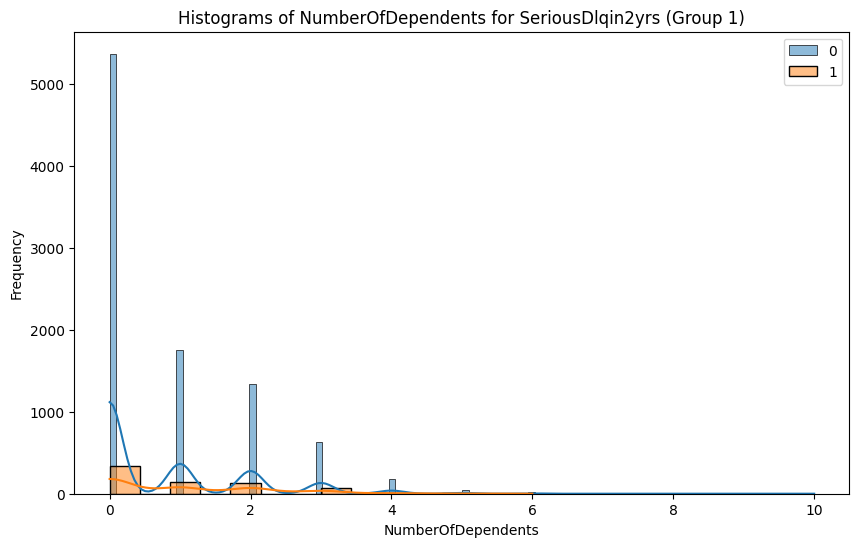

In [13]:
features = [col for col in train_set.columns if col != target]
for col in features:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 2)

*Visualmente se ve poco debido a los rangos y las diferencias de distribución, de hecho todas las que son "NumberOfTime" parecen interesantes (esa superposición naranaja sobre la azul en la larga cola) pero no son claras, y el resto salvo Age tampoco parece aportar mucho. Veamos las "NumberOfTime" separando las gráficas en vez de superponiéndolas*

In [14]:
numberOf = [col for col in train_set if col.startswith("NumberOfTime")]
for col in numberOf:
    print(f"Para pagadores, value_counts de {col}")
    print(train_set[train_set[target]== 0][col].value_counts(True))
    print(f"Para impagadores")
    print(train_set[train_set[target]==1][col].value_counts(True))
    print("****")

Para pagadores, value_counts de NumberOfTime30-59DaysPastDueNotWorse
NumberOfTime30-59DaysPastDueNotWorse
0     0.860956
1     0.100665
2     0.025300
3     0.006968
4     0.002895
5     0.001179
6     0.000858
98    0.000858
8     0.000214
7     0.000107
Name: proportion, dtype: float64
Para impagadores
NumberOfTime30-59DaysPastDueNotWorse
0     0.524964
1     0.245364
2     0.118402
3     0.049929
4     0.028531
98    0.011412
5     0.011412
6     0.009986
Name: proportion, dtype: float64
****
Para pagadores, value_counts de NumberOfTimes90DaysLate
NumberOfTimes90DaysLate
0     0.966660
1     0.024228
2     0.005253
3     0.002037
98    0.000858
4     0.000536
5     0.000214
13    0.000107
6     0.000107
Name: proportion, dtype: float64
Para impagadores
NumberOfTimes90DaysLate
0     0.651926
1     0.152639
2     0.089872
3     0.035663
4     0.031384
98    0.011412
5     0.009986
6     0.005706
7     0.004280
8     0.004280
9     0.001427
10    0.001427
Name: proportion, dtype: float

*Comparando números se puede ver que en general los pagagadores tienen la "NumberOfTime" a 0 y los impagadores en menor medida, por lo que son columnas que esperamos que sean bastante discriminativas. De hecho tal como se ve podríamos haberlas simplificado (por ejemplo en 3 valores, 0 veces, 1 vez, más de 1 vez)*

*Hora de seleccionar: Me quedo todas porque son pocas, de tener más tiempo habría hecho dos juegos uno con "Age",las "NumberOfTime" y "MonthlyIncome", otro con todas las features*

**5. Tratamiento de Features**

*Sí solo usase ensamblados basados en Árboles no trataría las variables, pero se nos pide usar un KNN, así que sabiendo lo sensible que es a las escalas, vamos a tratar todas las variables.*

*Veamos los histogramas*

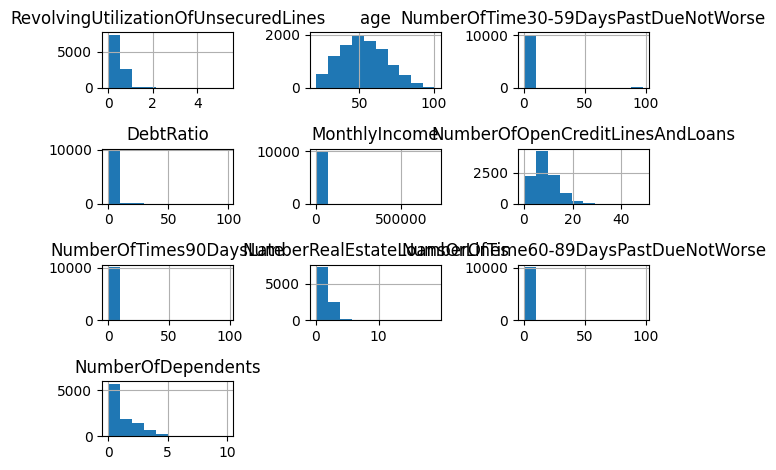

In [15]:
train_set[features].hist()
plt.tight_layout()

*Salvo Age todas necesitan un "empujoncito", pero voy a generar dos train_sets*

In [16]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [17]:
for col in features:
    if col != "age":
        train_set_scaled[col] = np.log(train_set_scaled[col] + 1) # A todas les aplicafo log(x+1) porque tienen ceros
        test_set_scaled[col] = np.log(test_set_scaled[col] + 1) # A test le tengo que aplicar las mismas transformaciones que a train

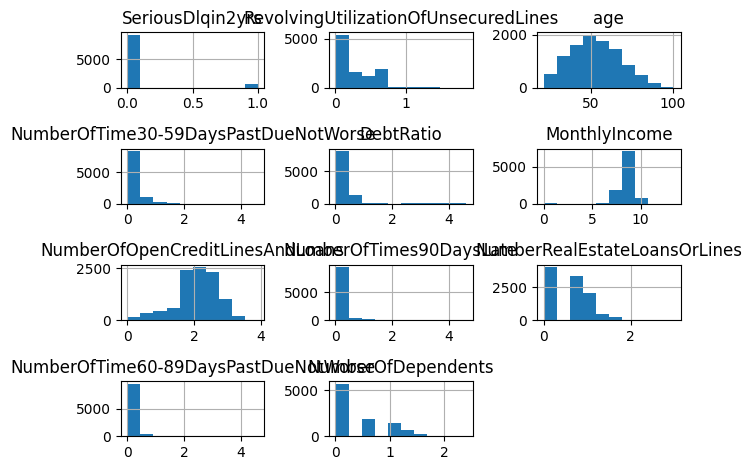

In [18]:
train_set_scaled.hist()
plt.tight_layout()

In [19]:
scaler = StandardScaler()
train_set_scaled[features] = scaler.fit_transform(train_set_scaled[features])
test_set_scaled[features] = scaler.transform(test_set_scaled[features])

**6. Generamos X,y**

*Generamos todos los juegos de X,y que necesitamos, teniendo en cuenta que tenemos un train sin escalar y otro escalado*

In [20]:
X_train = train_set[features]
X_train_scaled = train_set_scaled[features]
y_train = train_set[target]

X_test = test_set[features]
X_test_scaled = test_set_scaled[features]
y_test = test_set[target]


**7. Baseline con KNN**

*Escogemos K=7, arbitrariamente*

*Entrenamos*

In [21]:
knn_clf = KNeighborsClassifier(n_neighbors= 7)
knn_clf.fit(X_train_scaled, y_train)


KNeighborsClassifier(n_neighbors=7)

*Probamos contra Train*

In [22]:
print(classification_report(y_train, knn_clf.predict(X_train_scaled)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9328
           1       0.71      0.27      0.39       701

    accuracy                           0.94     10029
   macro avg       0.83      0.63      0.68     10029
weighted avg       0.93      0.94      0.93     10029



*Claramente no es un gran clasificador, pero ya tenemos un recall_medio "malo" para comparar -> 63%, fijate que no he usado el test, ni validación cruzada, pero tampoco lo he optimizado (no sabemos si es k es bueno o si el peso de los vecinos es el mejor), de hecho si pruebas con un "weights= "distance"" cambiarán bastante los resultados (contra train)*

**8. Otros Modelos y comparativa**

In [23]:
modelos = ["KNN","Logistic","RandomF","XGBoost","LightGBM"]
metricas = []
lr_clf = LogisticRegression(max_iter = 10000)
rf_clf = RandomForestClassifier(max_depth = 5, random_state = 42)
xgb_clf = XGBClassifier(max_depth = 5, random_state = 42)
lgb_clf = LGBMClassifier(max_depth= 5, verbose = -100, random_state = 42)

for nombre,modelo in zip(modelos,[knn_clf, lr_clf, rf_clf, xgb_clf, lgb_clf]):
    print(f"Para {nombre}:", end = " ")
    if nombre not in modelos[0:2]: # árboles sin escalar
        metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
    else:
        metrica = np.mean(cross_val_score(modelo, X_train_scaled, y_train, cv = 5, scoring = "balanced_accuracy"))
        #metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
    print(metrica)
    metricas.append(metrica)

Para KNN: 0.5844570166716769
Para Logistic: 0.5639755637804881
Para RandomF: 0.5541803547581452
Para XGBoost: 0.6009707304935455
Para LightGBM: 0.5929105536793011


*Solo teniendo en cuenta estos valores nos quedaríamos con LightGBM, pero claramente son malos si tenemos al KNN como baseline, y sabemos que tiene que ver con el desequilibrio del dataset o por lo menos ese debería ser nuestro primer punto de actuación*

**8. Equilibrado**

*Vamos a generar dos juegos nuevos de X,y uno con Oversampling y otro con Undersampling*

1. Oversampling con SMOTE

In [24]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote_scaled, y_train_smote_scaled = smote.fit_resample(X_train_scaled, y_train) # Esto es un poco camino corto: Ojo porque ahora no estamos entrenando contra los mismos trains exactamente para eso tendríamos que haber reescalado el X_train, usando los mismos valores originales.


In [25]:
modelos = ["KNN","Logistic","RandomF","XGBoost","LightGBM"]
metricas = []
lr_clf = LogisticRegression(max_iter = 10000)
rf_clf = RandomForestClassifier(max_depth = 5, random_state = 42)
xgb_clf = XGBClassifier(max_depth = 5, random_state = 42)
lgb_clf = LGBMClassifier(max_depth= 5, verbose = -100, random_state = 42)
model = []

for nombre,modelo in zip(modelos,[knn_clf, lr_clf, rf_clf, xgb_clf, lgb_clf]):
    model.append(modelo)
    print(f"Para {nombre}:", end = " ")
    if nombre not in modelos[0:2]:
        metrica = np.mean(cross_val_score(modelo, X_train_smote, y_train_smote, cv = 5, scoring = "balanced_accuracy"))
    else:
        metrica = np.mean(cross_val_score(modelo, X_train_smote_scaled, y_train_smote_scaled, cv = 5, scoring = "balanced_accuracy"))
        #metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
    print(metrica)
    metricas.append(metrica)

Para KNN: 0.8954758353950616
Para Logistic: 0.7818395788614663
Para RandomF: 0.8202200805151592
Para XGBoost: 0.9159556218373662
Para LightGBM: 0.9011614642150059


*Así de primeras parece que le ha sentado bastante bien, pero ojo como no estamos comparando contra trains iguales no podemos comparar directamente los valores anteriores con estos, sólo contra test nos valdría. Así de primeras lo único que me dice es que Mi elección de LightGBM de antes podría verse afectada, y decantarme por XGBoost (a KNN le sienta muy bien el smote entre otras cosas porque tiene algo de similitud en la creación de sintéticos). Para terminar de escoger, veamos el resto de equilibrados*

2. Undersampling


In [26]:
# Separar las clases mayoritaria y minoritaria
clase_mayoritaria = X_train[y_train == 0]
clase_minoritaria = X_train[y_train == 1]
clase_mayoritaria_scaled = X_train_scaled[y_train == 0]
clase_minoritaria_scaled = X_train_scaled[y_train == 1]



In [27]:

# Bajomuestrear la clase mayoritaria para no escalado
clase_mayoritaria_bajomuestreo = resample(clase_mayoritaria,
                                          replace=False,
                                          n_samples=len(clase_minoritaria),  # igual al número de la clase minoritaria
                                          random_state=42)

# Combinar la clase minoritaria con la clase mayoritaria bajomuestreada (importante es que resample mantiene los índices para que lo que viene a continuación tenga sentido)
X_train_bajomuestreo = pd.concat([clase_mayoritaria_bajomuestreo, clase_minoritaria])
y_train_bajomuestreo = pd.concat([y_train.loc[clase_mayoritaria_bajomuestreo.index], 
                                  y_train.loc[clase_minoritaria.index]])




In [28]:

# Bajomuestrear la clase mayoritaria para no escalado
clase_mayoritaria_bajomuestreo_scl = resample(clase_mayoritaria_scaled,
                                          replace=False,
                                          n_samples=len(clase_minoritaria_scaled),  # igual al número de la clase minoritaria
                                          random_state=42)

# Combinar la clase minoritaria con la clase mayoritaria bajomuestreada (importante es que resample mantiene los índices para que lo que viene a continuación tenga sentido)
X_train_bajomuestreo_scl = pd.concat([clase_mayoritaria_bajomuestreo_scl, clase_minoritaria_scaled])
y_train_bajomuestreo_scl = pd.concat([y_train.loc[clase_mayoritaria_bajomuestreo_scl.index], 
                                  y_train.loc[clase_minoritaria_scaled.index]])

In [29]:
modelos = ["KNN","Logistic","RandomF","XGBoost","LightGBM"]
metricas = []
lr_clf = LogisticRegression(max_iter = 10000)
rf_clf = RandomForestClassifier(max_depth = 5, random_state = 42)
xgb_clf = XGBClassifier(max_depth = 5, random_state = 42)
lgb_clf = LGBMClassifier(max_depth= 5, verbose = -100, random_state = 42)
model = []

for nombre,modelo in zip(modelos,[knn_clf, lr_clf, rf_clf, xgb_clf, lgb_clf]):
    model.append(modelo)
    print(f"Para {nombre}:", end = " ")
    if nombre not in modelos[0:2]:
        metrica = np.mean(cross_val_score(modelo, X_train_bajomuestreo, y_train_bajomuestreo, cv = 5, scoring = "balanced_accuracy"))
    else:
        metrica = np.mean(cross_val_score(modelo, X_train_bajomuestreo_scl, y_train_bajomuestreo_scl, cv = 5, scoring = "balanced_accuracy"))
        #metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
    print(metrica)
    metricas.append(metrica)

Para KNN: 0.7646200607902734
Para Logistic: 0.7696555217831813
Para RandomF: 0.77322695035461
Para XGBoost: 0.7546099290780142
Para LightGBM: 0.7738956433637285


*LightGBM es un pelín superior (pero realmente no hay una diferencia real con Random o Logistic), y se mantiene a la cabeza en todas las pruebas, auque sea por poco*

3. Pesando en entrenamiento

*En este caso KNN quedaría fuera, porque no podemos aplicar nada de forma directa, pero vamos a usar su otro hiperparámetro que nos dice que los vecinos más cercanos aportan más*

In [30]:
modelos = ["KNN","Logistic","RandomF","XGBoost","LightGBM"]
metricas = []
knn_clf = KNeighborsClassifier(n_neighbors= 7, weights= "distance")
lr_clf = LogisticRegression(max_iter = 10000, class_weight= "balanced")
rf_clf = RandomForestClassifier(max_depth = 5, random_state = 42, class_weight= "balanced")
xgb_clf = XGBClassifier(max_depth = 5, random_state = 42, scale_pos_weight = len(train_set[train_set[target] == 0])/len(train_set[target] == 1))
lgb_clf = LGBMClassifier(max_depth= 5, verbose = -100, random_state = 42, class_weight= "balanced")

for nombre,modelo in zip(modelos,[knn_clf, lr_clf, rf_clf, xgb_clf, lgb_clf]):
    print(f"Para {nombre}:", end = " ")
    if nombre not in modelos[0:2]:
        metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
    else:
        metrica = np.mean(cross_val_score(modelo, X_train_scaled, y_train, cv = 5, scoring = "balanced_accuracy"))
        #metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
    print(metrica)
    metricas.append(metrica)

Para KNN: 0.5853496249498701
Para Logistic: 0.7675397937381716
Para RandomF: 0.7605129091663694
Para XGBoost: 0.5856368170211439
Para LightGBM: 0.7575075864255721


*Finalmente, LightGBM cae un pelín pero está entre los tres primeros sin perder mucho. Teniendo en cuenta las cuatro validaciones, ¿qué modelo escoger? En este caso en el que sin tocar los dataset LightGBM era mejor y luego se ha mantenido, escogería LightGBM como modelo para terminar de ajustar sus hiperparámetros. Además haría dos ajustes: uno contra el dataset Oversampleado y otro contra el dataset normal en el que incluiría el class_weight balanced.. Veámoslo si da tiempo*

**9.Ajuste de hiperparámetros del modelo ganador**

9.1 Sobre dataset sin alterar

In [31]:
### LightGBM

param_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.1,0.5,1],
    "max_depth": [5,10,15],
    "min_data_in_leaf": [1,10,20,100],
    "class_weight":["balanced",None]
}

lgb_clf = LGBMClassifier(verbose = -100)
lgb_grid = GridSearchCV(lgb_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring= "balanced_accuracy")

lgb_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbose=-100),
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [5, 10, 15],
                         'min_data_in_leaf': [1, 10, 20, 100],
                         'n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [32]:
lgb_grid.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_data_in_leaf': 100,
 'n_estimators': 100}

In [33]:
lgb_grid.best_score_

np.float64(0.7668397945914842)

In [34]:
print(classification_report(y_test, lgb_grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      2345
           1       0.21      0.67      0.32       163

    accuracy                           0.82      2508
   macro avg       0.59      0.75      0.61      2508
weighted avg       0.92      0.82      0.86      2508



*Ahora vamos a probar con el train creado con SMOTE*

In [35]:
### LightGBM con SMOTE

param_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.1,0.5,1],
    "max_depth": [5,10,15],
    "min_data_in_leaf": [1,10,20,100]
}

lgb_clf = LGBMClassifier(verbose = -100)
lgb_grid_smote = GridSearchCV(lgb_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring= "balanced_accuracy")

lgb_grid_smote.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbose=-100),
             param_grid={'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [5, 10, 15],
                         'min_data_in_leaf': [1, 10, 20, 100],
                         'n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [36]:
lgb_grid_smote.best_params_

{'learning_rate': 0.5,
 'max_depth': 15,
 'min_data_in_leaf': 10,
 'n_estimators': 200}

In [37]:
lgb_grid_smote.best_score_

np.float64(0.941791505392102)

In [38]:
print(classification_report(y_test, lgb_grid_smote.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2345
           1       0.28      0.28      0.28       163

    accuracy                           0.91      2508
   macro avg       0.62      0.62      0.62      2508
weighted avg       0.91      0.91      0.91      2508



*Pues nos quedaríamos con el modelo entrenado con class_weight y no con el entrenado con datos sintéticos,principalmente por los resultados y entre otras cosas porque a mí me parece más "natural" :-)*

**10. Análisis de Errores**

*Como nuestra medida es el recall medio pintamos la matriz con esos porcentajes, es decir la distribución por filas (los porcentajes por filas suman 100)*

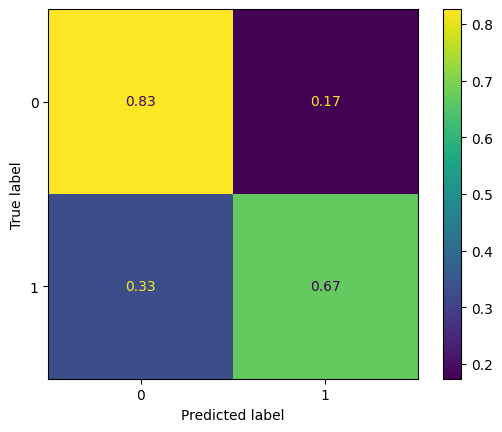

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, lgb_grid.best_estimator_.predict(X_test), normalize = "true")

### EXTRA: Comparación de errores con probabilidades en clase 1

*En el caso de una clasificación binaria la matriz de confusión nos dice lo evidente, nos equivocamos en dirección de la otra clase. Por eso puede ser más interesante ver instancias individuales, por ejemplo en la clase 1, con probabilidad alta*

In [40]:
y_proba = lgb_grid.best_estimator_.predict_proba(X_test)[:,1]


In [41]:
y_pred = lgb_grid.best_estimator_.predict(X_test)
error_set = test_set.copy()
error_set["proba"] = y_proba
error_set["predict_class"] = y_pred
bien_clasificadas = error_set[target] == error_set["predict_class"]
mal_clasificadas = bien_clasificadas == False
clase_1 = error_set[target] == 1


In [42]:
error_set.iloc[:4].loc[:,["proba", "predict_class"]]

,proba,predict_class
9525,0.093917,0
2984,0.299990,0
6247,0.201739,0
9931,0.928725,1


In [43]:
error_set.iloc[:4,-4:]

,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,proba,predict_class
9525,0,1.0,0.093917,0
2984,0,1.0,0.299990,0
6247,0,0.0,0.201739,0
9931,1,0.0,0.928725,1


In [44]:
bien_clasificadas.iloc[:4]

9525     True
2984     True
6247     True
9931    False
dtype: bool

In [45]:
mal_clasificadas.iloc[:4]

9525    False
2984    False
6247    False
9931     True
dtype: bool

In [46]:
clase_1.iloc[:4]

9525    False
2984    False
6247    False
9931    False
Name: SeriousDlqin2yrs, dtype: bool

<Axes: >

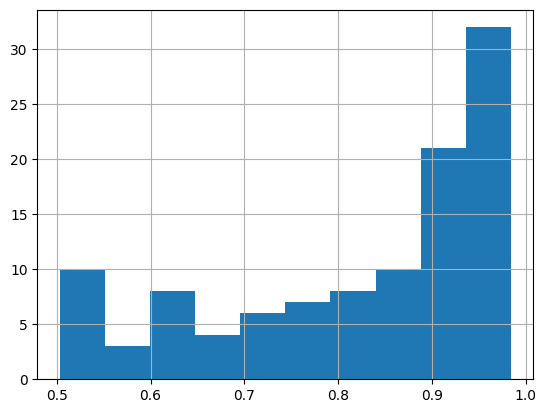

In [47]:
error_set[bien_clasificadas & clase_1].proba.hist()

<Axes: >

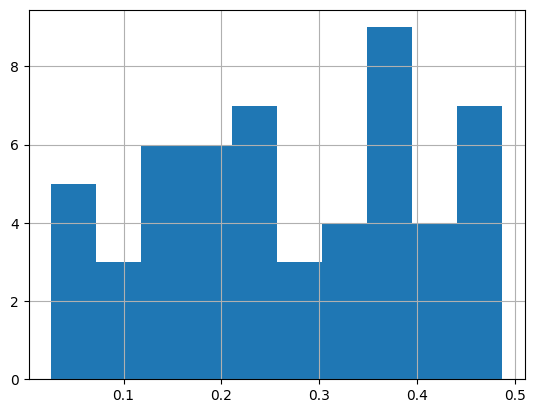

In [48]:
error_set[mal_clasificadas & clase_1].proba.hist()

*Este gráfico nos dice que cuando se equivoca con la clase 1 lo hace con probabilidades más o menos igual distribuidas, frente a cuando lo hace bien que se ve que se acumulan los exitos en probabilidades altas, podríamos intentar ver qué caracteriza a estos errores o a los de probabilidades más bajas de 0.25 o menos por entender si hay algo que esté sesgando al modelo, y corregirlo*